In [9]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='6f9e0f3c-80e1-4e4b-b1bc-58a0b3ea4754', project_access_token='p-5e1c56d572d62dccefd0323a6db9de21140f2957')
pc = project.project_context

<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Tutorial on generating an explanation for an image-based binary classifier model on Watson OpenScale

## Contents:
- [1. Setup](#setup)
- [2. Creating and deploying an image-based model](#deployment)
- [3. Subscriptions](#subscription)
- [4. Explainability](#explainability)

<a id="setup"></a>
## 1. Setup

### 1.1 Install OS and WML packages

In [ ]:
!pip install --upgrade ibm-watson-openscale --no-cache | tail -n 1

In [ ]:
!pip install --upgrade ibm-watson-machine-learning --no-cache | tail -n 1

Note: Restart the kernel to assure the new libraries are being used.

### 1.2 Configure credentials

Your Cloud API key can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below.

**NOTE:** You can also get OpenScale `API_KEY` using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: [instruction](https://console.bluemix.net/docs/cli/reference/ibmcloud/download_cli.html#install_use)

How to get api key using console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

In [1]:
CLOUD_API_KEY = "wqMwzhQ7GRNBlH5iS3OVGlf3Ym4OD4EPJjaA6Eg8mQgg"
IAM_URL="https://iam.ng.bluemix.net/oidc/token"

In [2]:
WML_CREDENTIALS = {
                   "url": "https://us-south.ml.cloud.ibm.com",
                   "apikey": CLOUD_API_KEY
}

<a id="deployment"></a>
## 2. Creating and deploying an image-based model

We are going to create a binary classifier which classifies an image as a Dog or a Cat (Probability: 1 = dog, 0 = cat). The dataset can be downloaded from here: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data. The dataset can also be found here: https://ibm.box.com/shared/static/itl0el289mz06py2e6aemehx6lge1rou.zip

Now, create a folder named `data` and inside it create subdirectories: `train` and `validation`. Further, create folders named `dogs` and `cats` (as shown below) with 1024 dog and cat images in the `train` directory and 416 dog and cat images in the `validation` directory respectively. Post unzipping the downloaded zip file, use the images from the `train` folder found after unzipping `train.zip`.

```python
data/
    train/
        dogs/ # 1024 pictures
            dog.1.jpg
            dog.2.jpg
            ...
        cats/ # 1024 pictures
            cat.1.jpg
            cat.2.jpg
            ...
    validation/
        dogs/ # 416 pictures
            dog.1025.jpg
            dog.1026.jpg
            ...
        cats/ # 416 pictures
            cat.1025.jpg
            cat.1026.jpg
            ...
```

Note: Keras and TensorFlow versions supported by WML are: Keras 2.2.5 with TensorFlow 1.15 backend. This combination is used in this notebook.

In [3]:
!pip install keras==2.2.5
!pip install tensorflow==1.15.0
!pip install keras_sequential_ascii
!pip install numpy
!pip install pillow

import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as keras_backend
from keras import optimizers
from keras import applications
from keras.models import Model
import numpy as np
print(keras.__version__)

     |████████████████████████████████| 336 kB 10.6 MB/s eta 0:00:01
     |████████████████████████████████| 412.3 MB 31 kB/s s eta 0:00:01MB 57.1 MB/s eta 0:00:06     |█████████████▋                  | 175.7 MB 65.5 MB/s eta 0:00:04     |███████████████████████████▋    | 356.4 MB 31.2 MB/s eta 0:00:02
     |████████████████████████████████| 503 kB 28.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 61.1 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0
  Created 

Using TensorFlow backend.


2.2.5


#### Insert project token in notebook and use to upload train and validation zip in data assets and load in notebook

In [12]:
import zipfile
def get_zip(file_name):
    '''
    file_name = Name of zip file you want to download from object storage
    '''
    try:
        fobj = open(file_name, "wb")
        fobj.write(project.get_file(file_name).read()) 
        fobj.close()
        z = zipfile.ZipFile(file_name)
        z.extractall()
    except Exception as e:
        print(Exception,e)
    else:
        print('Files downloaded successfully') 

In [11]:
get_zip('train.zip')
get_zip('validation.zip')

Files downloaded successfully
Files downloaded successfully


### 2.1 Creating a model

In [13]:
!ls

library_content.tar.gz	__MACOSX  train  train.zip  validation	validation.zip


In [14]:
# Dimension of the images
img_width, img_height = 90, 90

train_data_dir = 'train/'
validation_data_dir = 'validation/'

Note: Please modify the paths above accordingly.

In [15]:
# Preprocessing

#used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 22240 images belonging to 2 classes.
Found 2760 images belonging to 2 classes.


In [16]:
# Define Model

def base_model():
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    return model

In [17]:
epochs = 10 # One can increase the no. of epochs to get better accuracy
train_samples = 2048
validation_samples = 832

In [18]:
cnn_n = base_model()
cnn_n.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 88, 88, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 88, 88, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 42, 42, 32)        0         
____________________________________

In [19]:
# Vizualizing model structure
sequential_model_to_ascii_printout(cnn_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     90   90    3
              Conv2D    \|/  -------------------       896     0.2%
                relu   #####     88   88   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     44   44   32
              Conv2D    \|/  -------------------      9248     2.6%
                relu   #####     42   42   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     21   21   32
              Conv2D    \|/  -------------------     18496     5.1%
                relu   #####     19   19   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      9    9   64
             Dropout    | || -------------------         0     0.0%
                       #####      9    9   64
             Flatten   ||||| -------------------         0     0.0%
              

In [20]:
# Train the model
cnn_n.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_steps=validation_samples // batch_size,
    validation_data=validation_generator
)




Epoch 1/10





64/64 [==============================] - 37s 586ms/step - loss: 0.6983 - acc: 0.5303 - val_loss: 0.6819 - val_acc: 0.5853
Epoch 2/10
64/64 [==============================] - 35s 548ms/step - loss: 0.6889 - acc: 0.5547 - val_loss: 0.6728 - val_acc: 0.5529
Epoch 3/10
64/64 [==============================] - 35s 542ms/step - loss: 0.6576 - acc: 0.6104 - val_loss: 0.6114 - val_acc: 0.6731
Epoch 4/10
64/64 [==============================] - 36s 556ms/step - loss: 0.6357 - acc: 0.6372 - val_loss: 0.6075 - val_acc: 0.6683
Epoch 5/10
64/64 [==============================] - 35s 542ms/step - loss: 0.6114 - acc: 0.6655 - val_loss: 0.5921 - val_acc: 0.6851
Epoch 6/10
64/64 [==============================] - 35s 550ms/step - loss: 0.5873 - acc: 0.6816 - val_loss: 0.6220 - val_acc: 0.6587
Epoch 7/10
64/64 [==============================] - 35s 555ms/step - loss: 0.5916 - acc: 0.7026 - val_loss: 0.6639 - val_acc: 0.6386
Epoch 8/10
64/64 [==============================] - 34s 539ms

In [25]:
!ls

dog_cat_cnn.h5	    library_content.tar.gz  train      validation
dog_cat_cnn.tar.gz  __MACOSX		    train.zip  validation.zip


In [24]:
cnn_n.save('dog_cat_cnn.h5')
!rm dog_cat_cnn.tar*
!tar -czvf dog_cat_cnn.tar.gz dog_cat_cnn.h5
!rm dog_cat_cnn.h5

dog_cat_cnn.h5


In [26]:
# from IPython.display import HTML
# import base64
# import io

# def create_download_link_for_ddm( title = "Download model zip", filename = "dog_cat_cnn.tar.gz"):  
    
#     #Retains stats information    

#     with open(filename,'rb') as file:
#         ddm = file.read()
#     b64 = base64.b64encode(ddm)
#     payload = b64.decode()

#     html = '<a download="{filename}" href="data:text/json;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)


# create_download_link_for_ddm()

In [27]:
scores = cnn_n.evaluate_generator(validation_generator, validation_samples)
print(scores)
print("Accuracy: %.2f%%" % (scores[1]*100))

[0.5252428137327967, 0.7380339291123902]
Accuracy: 73.80%


### 2.2 Storing the model

In [29]:
import json
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(WML_CREDENTIALS)
wml_client.version

'1.0.38'

In [30]:
wml_client.spaces.list(limit=10)

------------------------------------  --------------  ------------------------
ID                                    NAME            CREATED
7fb100d2-bfb3-40f6-8a61-9daf733a16aa  prod-space      2020-10-26T22:28:31.105Z
4892166c-6285-47f8-9f3f-b9c3c541a4a2  pre-prod-space  2020-10-26T21:25:32.230Z
a2c5ddbd-c002-4c86-ab07-ce7334fbfa4d  test_v4         2020-09-30T19:38:26.229Z
------------------------------------  --------------  ------------------------


In [31]:
WML_SPACE_ID='a2c5ddbd-c002-4c86-ab07-ce7334fbfa4d' # use space id here
wml_client.set.default_space(WML_SPACE_ID)

'SUCCESS'

In [34]:
MODEL_NAME = "Dog-Cat binary"

In [33]:
wml_client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029a-cc97-56da-b8e0-39c3880dbbe7  base
tensorflow_2.1-py3.6           1eb25b8

In [35]:
software_spec_uid = wml_client.software_specifications.get_id_by_name("tensorflow_1.15-py3.6")
print("Software Specification ID: {}".format(software_spec_uid))
model_props = {
        wml_client._models.ConfigurationMetaNames.NAME:"{}".format(MODEL_NAME),
        wml_client._models.ConfigurationMetaNames.SPACE_UID: WML_SPACE_ID,
        wml_client._models.ConfigurationMetaNames.TYPE: "keras_2.2.5",
        wml_client._models.ConfigurationMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    }

Software Specification ID: 2b73a275-7cbf-420b-a912-eae7f436e0bc


In [36]:
print("Storing model ...")
published_model_details = wml_client.repository.store_model(
    model='dog_cat_cnn.tar.gz', 
    meta_props=model_props, 
)

model_uid = wml_client.repository.get_model_uid(published_model_details)
print("Done")
print("Model ID: {}".format(model_uid))

Storing model ...
Done
Model ID: 8692d03e-8999-4632-a341-71f89c8bb9b4


### 2.3 Deploying the model

In [37]:
deployment_details = wml_client.deployments.create(
    model_uid, 
    meta_props={
        wml_client.deployments.ConfigurationMetaNames.NAME: "{}".format(MODEL_NAME + " deployment"),
        wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
)
scoring_url = wml_client.deployments.get_scoring_href(deployment_details)
deployment_uid=wml_client.deployments.get_uid(deployment_details)

print("Scoring URL:" + scoring_url)
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))



#######################################################################################

Synchronous deployment creation for uid: '8692d03e-8999-4632-a341-71f89c8bb9b4' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c'
------------------------------------------------------------------------------------------------


Scoring URL:https://us-south.ml.cloud.ibm.com/ml/v4/deployments/5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c/predictions
Model id: 8692d03e-8999-4632-a341-71f89c8bb9b4
Deployment id: 5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c


## 3. Subscriptions <a id="subscription"></a>

### 3.1 Configuring OpenScale

(90, 90, 3)


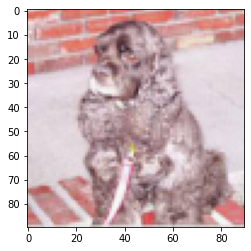

In [80]:
!pip install matplotlib
!pip install opencv-python

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import matplotlib.image as mpimg
from skimage.transform import resize

img = mpimg.imread("train/dogs/dog.8022.jpg")
img = resize(img, (90, 90))
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [44]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *


authenticator = IAMAuthenticator(apikey=CLOUD_API_KEY)
#authenticator = BearerTokenAuthenticator(bearer_token=IAM_TOKEN) ## uncomment this line if using IAM token to authenticate
wos_client = APIClient(authenticator=authenticator)
wos_client.version

'3.0.2'

In [45]:
#DB_CREDENTIALS= {"hostname":"","username":"","password":"","database":"","port":"","ssl":True,"sslmode":"","certificate_base64":""}
DB_CREDENTIALS = None
KEEP_MY_INTERNAL_POSTGRES = True

In [46]:
data_marts = wos_client.data_marts.list().result.data_marts
if len(data_marts) == 0:
    if DB_CREDENTIALS is not None:
        if SCHEMA_NAME is None: 
            print("Please specify the SCHEMA_NAME and rerun the cell")

        print('Setting up external datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook",
                database_configuration=DatabaseConfigurationRequest(
                  database_type=DatabaseType.POSTGRESQL,
                    credentials=PrimaryStorageCredentialsLong(
                        hostname=DB_CREDENTIALS['hostname'],
                        username=DB_CREDENTIALS['username'],
                        password=DB_CREDENTIALS['password'],
                        db=DB_CREDENTIALS['database'],
                        port=DB_CREDENTIALS['port'],
                        ssl=True,
                        sslmode=DB_CREDENTIALS['sslmode'],
                        certificate_base64=DB_CREDENTIALS['certificate_base64']
                    ),
                    location=LocationSchemaName(
                        schema_name= SCHEMA_NAME
                    )
                )
             ).result
    else:
        print('Setting up internal datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by WOS tutorial notebook", 
                internal_database = True).result
        
    data_mart_id = added_data_mart_result.metadata.id
    
else:
    data_mart_id=data_marts[0].metadata.id
    print('Using existing datamart {}'.format(data_mart_id))

Using existing datamart 5a0b9076-fcf6-49e8-a824-9e3a6b4c2a56


In [50]:
SERVICE_PROVIDER_NAME = "Watson Machine Learning V2_test"
SERVICE_PROVIDER_DESCRIPTION = "Added by tutorial WOS notebook."

In [51]:
service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for WML instance: {}".format(service_provider_id))

Deleted existing service_provider for WML instance: 457d36c4-6fa3-4300-be21-785efb13fe53


In [52]:
added_service_provider_result = wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description=SERVICE_PROVIDER_DESCRIPTION,
        service_type=ServiceTypes.WATSON_MACHINE_LEARNING,
        deployment_space_id = WML_SPACE_ID,
        operational_space_id = "production",
        credentials=WMLCredentialsCloud(
            apikey=CLOUD_API_KEY,      ## use `apikey=IAM_TOKEN` if using IAM_TOKEN to initiate client
            url=WML_CREDENTIALS["url"],
            instance_id=None
        ),
        background_mode=False
    ).result
service_provider_id = added_service_provider_result.metadata.id




 Waiting for end of adding service provider 59d3a7f1-3ee6-484e-a472-a947a82868eb 




active

-----------------------------------------------
 Successfully finished adding service provider 
-----------------------------------------------




In [56]:
asset_deployment_details_list = wos_client.service_providers.list_assets(data_mart_id=data_mart_id, service_provider_id=service_provider_id, deployment_space_id = WML_SPACE_ID).result['resources']
DEPLOYMENT_NAME=MODEL_NAME + " deployment" # use the model name here 
asset_deployment_details = [asset for asset in asset_deployment_details_list if asset['entity']["name"]==DEPLOYMENT_NAME]

if len(asset_deployment_details)>0:
    [asset_deployment_details] = asset_deployment_details
else:
    raise ValueError('deployment with name "{}" not found.'.format(DEPLOYMENT_NAME))
asset_deployment_details

{'metadata': {'guid': '5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c',
  'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c?space_id=a2c5ddbd-c002-4c86-ab07-ce7334fbfa4d',
  'created_at': '2020-11-04T22:00:49.757Z',
  'modified_at': '2020-11-04T22:00:49.757Z'},
 'entity': {'name': 'Dog-Cat binary deployment',
  'type': 'online',
  'scoring_endpoint': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c/predictions'},
  'asset': {},
  'asset_properties': {}}}

In [57]:
model_asset_details_from_deployment=wos_client.service_providers.get_deployment_asset(data_mart_id=data_mart_id,service_provider_id=service_provider_id,deployment_id=deployment_uid,deployment_space_id=WML_SPACE_ID)
model_asset_details_from_deployment

{'metadata': {'guid': '5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c',
  'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c?space_id=a2c5ddbd-c002-4c86-ab07-ce7334fbfa4d',
  'created_at': '2020-11-04T22:00:49.757Z',
  'modified_at': '2020-11-04T22:00:49.757Z'},
 'entity': {'name': 'Dog-Cat binary deployment',
  'type': 'online',
  'scoring_endpoint': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c/predictions'},
  'asset': {'asset_id': '8692d03e-8999-4632-a341-71f89c8bb9b4',
   'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/models/8692d03e-8999-4632-a341-71f89c8bb9b4?space_id=a2c5ddbd-c002-4c86-ab07-ce7334fbfa4d&version=2020-06-12',
   'name': 'Dog-Cat binary',
   'asset_type': 'model',
   'created_at': '2020-11-04T22:00:04.482Z',
   'modified_at': '2020-11-04T22:00:07.532Z'},
  'asset_properties': {'model_type': 'keras_2.2.5',
   'runtime_environment': 'python-3.6'}}}

### 3.2 Subscribe the asset

In [58]:
subscriptions = wos_client.subscriptions.list().result.subscriptions
for subscription in subscriptions:
    sub_model_id = subscription.entity.asset.asset_id
    if sub_model_id == model_uid:
        wos_client.subscriptions.delete(subscription.metadata.id)
        print('Deleted existing subscription for model', model_uid)

In [59]:
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=Asset(
            asset_id=model_asset_details_from_deployment["entity"]["asset"]["asset_id"],
            name=model_asset_details_from_deployment["entity"]["asset"]["name"],
            url=model_asset_details_from_deployment["entity"]["asset"]["url"],
            asset_type=AssetTypes.MODEL,
            input_data_type=InputDataType.UNSTRUCTURED_IMAGE,
            problem_type=ProblemType.BINARY_CLASSIFICATION
        ),
        deployment=AssetDeploymentRequest(
            deployment_id=asset_deployment_details['metadata']['guid'],
            name=asset_deployment_details['entity']['name'],
            deployment_type= DeploymentTypes.ONLINE,
            url=asset_deployment_details['metadata']['url']
        ),
        asset_properties=AssetPropertiesRequest(
            probability_fields=['probability']
            )
    ).result
subscription_id = subscription_details.metadata.id
subscription_id

'5aca8962-e2f8-4141-ace0-6994a8d6e1c5'

In [82]:
import time

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  a6e7e82b-017e-467e-bb27-3d413126f22a


### 3.3 Score the model and get transaction-id

In [83]:
scoring_data={"input_data": [{"values": [img.tolist()]}]}
predictions = wml_client.deployments.score(deployment_uid, scoring_data)
print(predictions)

{'predictions': [{'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[0.37867844104766846], [0], [0.37867844104766846]]]}]}


In [84]:
wos_client.data_sets.get_records_count(payload_data_set_id)

2

<a id="explainability"></a>
## 4. Explainability

### 4.1 Configure Explainability

In [85]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result

explainability_monitor_id = explainability_details.metadata.id




 Waiting for end of monitor instance creation 50ff18b6-f1b7-4996-b96b-6340a93c9398 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




### 4.2 Get explanation for the transaction

In [86]:
pl_records_resp = wos_client.data_sets.get_list_of_records(data_set_id=payload_data_set_id, limit=1, offset=0).result
scoring_ids = [pl_records_resp["records"][0]["entity"]["values"]["scoring_id"]]
print("Running explanations on scoring IDs: {}".format(scoring_ids))
explanation_types = ["lime", "contrastive"]
result = wos_client.monitor_instances.explanation_tasks(scoring_ids=scoring_ids, explanation_types=explanation_types).result
print(result)

Running explanations on scoring IDs: ['519558b670fdecb34e206a227ea9dec3-1']
{
  "metadata": {
    "explanation_task_ids": [
      "b01c751a-61cd-4839-9bad-d0ab8f740869"
    ],
    "created_by": "IBMid-310002F0G1",
    "created_at": "2020-11-04T22:33:43.736962Z"
  }
}


In [99]:
explanation_task_id=result.to_dict()['metadata']['explanation_task_ids'][0]
explanation=wos_client.monitor_instances.get_explanation_tasks(explanation_task_id=explanation_task_id).result.to_dict()

{'metadata': {'explanation_task_id': 'b01c751a-61cd-4839-9bad-d0ab8f740869',
  'created_by': 'IBMid-310002F0G1',
  'created_at': '2020-11-04T22:33:43.736962Z',
  'updated_at': '2020-11-04T22:37:03.514687Z'},
 'entity': {'status': {'state': 'finished'},
  'asset': {'id': '8692d03e-8999-4632-a341-71f89c8bb9b4',
   'name': 'Dog-Cat binary',
   'input_data_type': 'unstructured_image',
   'problem_type': 'binary',
   'deployment': {'id': '5bf54ad1-64e7-47e1-ba5b-49cd15ea1b7c',
    'name': 'Dog-Cat binary deployment'}},
  'input_features': [{}],
  'explanations': [{'explanation_type': 'lime',
    'predictions': [{'probability': 0.6213215589523315,
      'value': 0,
      'explanation': [{'full_image': 'iVBORw0KGgoAAAANSUhEUgAAAFoAAABaCAIAAAC3ytZVAAAz30lEQVR42s28aZBmaVYedt71rt++5Jd71l7Ve0/PjodhQBgJGSkwDsIKYWOLCFkeKQyBQA5pJFsSmLBkC2HLYBy2JFuhH7ZMgLEGMBFmEJqtmZ6e6e7qqupauiqzKtcvv/2u7+4fN+vrHmYY2rJcM/dHxpc37715z/Oe85xznvNmor3rN6yWxKpyNjXZwhQpR65Mx2J4P5hDZHyFKGo1/F7z0cEjND31AMXc94FYqcBaQqnfiA9CGQ

### The explanation images can be obtained using the cells below

Explanation for 0 region:


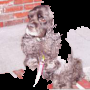

In [118]:
!pip install Pillow
from PIL import Image
import base64
import io

pred = explanation["entity"]['explanations'][0]['predictions'][0]
print("Explanation for {} region:".format(pred["value"]))

img = pred["explanation"][0]["full_image"]
img_data = base64.b64decode(img)
Image.open(io.BytesIO(img_data))

Explanation for Others region:


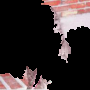

In [119]:
pred = pred = explanation["entity"]['explanations'][0]['predictions'][1]
print("Explanation for {} region:".format(pred["value"]))

img = pred["explanation"][0]["full_image"]
img_data = base64.b64decode(img)
Image.open(io.BytesIO(img_data))